<a href="https://colab.research.google.com/github/Ib-Ca/SkinCancer/blob/main/SkinCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de cancer de Piel.
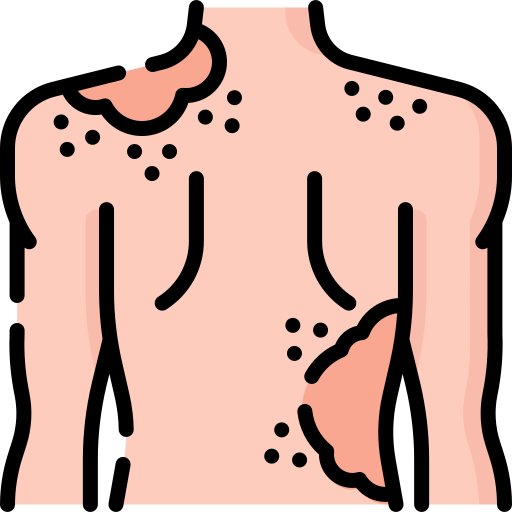


##Importación de librerías.






In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, time, shutil
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier
from PIL import Image
from glob import glob
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve,auc,roc_auc_score,ConfusionMatrixDisplay

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Importación de Datos




In [ ]:
#!ls "/content/drive/My Drive/IA"
#archivos
data_path = "/content/drive/My Drive/IA"
metadata = pd.read_csv(os.path.join(data_path, "HAM10000_metadata.csv"))
hmnist_8_8_l = pd.read_csv(os.path.join(data_path, "hmnist_8_8_L.csv"))
hmnist_8_8_rgb = pd.read_csv(os.path.join(data_path, "hmnist_8_8_RGB.csv"))
hmnist_28_28_l = pd.read_csv(os.path.join(data_path, "hmnist_28_28_L.csv"))
hmnist_28_28_rgb = pd.read_csv(os.path.join(data_path, "hmnist_28_28_RGB.csv"))

base_dir = os.path.join(data_path, 'SkinCancer')
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')

#print(train_dir)
#print(val_dir)
#print(base_dir)

#ver si hay valores no validos
metadata.describe()
metadata.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0


In [ ]:
#rellenar los valores edad con la edad promedio
metadata['age'].fillna(int(metadata['age'].mean()),inplace=True)

<ipython-input-3-ec3688d4d987>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata['age'].fillna(int(metadata['age'].mean()),inplace=True)


In [ ]:
metadata.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0


In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = '/content/drive/My Drive/IA'
target_dirs = ['HAM10000_images_part_1', 'HAM10000_images_part_2']

imageid_path_dict = {}
for dir_name in target_dirs:
    search_path = os.path.join(base_skin_dir, dir_name, '*.jpg')
    for x in glob(search_path):
        imageid_path_dict[os.path.splitext(os.path.basename(x))[0]] = x

In [ ]:
metadata['path'] = metadata['image_id'].map(imageid_path_dict.get)
metadata['cell_type'] = metadata['dx'].map(lesion_type_dict.get)
metadata['cell_type_idx'] = pd.Categorical(metadata['cell_type']).codes
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/My Drive/IA/HAM10000_images_par...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/My Drive/IA/HAM10000_images_par...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/My Drive/IA/HAM10000_images_par...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/My Drive/IA/HAM10000_images_par...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/My Drive/IA/HAM10000_images_par...,Benign keratosis-like lesions,2


In [ ]:
train_dir = os.path.join(base_skin_dir, 'train_dir')
# val_dir
val_dir = os.path.join(base_skin_dir, 'val_dir')



In [ ]:
#cuantas imagenes estan asociadas a cada lesion_id
df = metadata.groupby('lesion_id').count()

#filtrar todas las "lesion_id" que tengan una sola imagen
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [ ]:
def identify_duplicates(x):

    unique_list = list(df['lesion_id'])

    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

metadata['duplicates'] = metadata['lesion_id']
metadata['duplicates'] = metadata['duplicates'].apply(identify_duplicates)

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/My Drive/IA/HAM10000_images_par...,Benign keratosis-like lesions,2,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/My Drive/IA/HAM10000_images_par...,Benign keratosis-like lesions,2,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/My Drive/IA/HAM10000_images_par...,Benign keratosis-like lesions,2,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/My Drive/IA/HAM10000_images_par...,Benign keratosis-like lesions,2,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/My Drive/IA/HAM10000_images_par...,Benign keratosis-like lesions,2,has_duplicates


In [ ]:
metadata['duplicates'].value_counts()


,count
duplicates,
no_duplicates,5514
has_duplicates,4501


In [ ]:
df = metadata[metadata['duplicates'] == 'no_duplicates']
df.shape

(5514, 11)

In [ ]:
#creamos un set de validacion con las que no son duplicadas
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(938, 11)

In [ ]:
df_val['cell_type'].value_counts()

,count
cell_type,
Melanocytic nevi,751
Benign keratosis-like lesions,75
Melanoma,39
Basal cell carcinoma,30
Actinic keratoses,26
Vascular lesions,11
Dermatofibroma,6


In [ ]:
def identify_val_rows(x):
    val_list = list(df_val['image_id'])

    if str(x) in val_list:
        return 'val'
    else:
        return 'train'


metadata['train_or_val'] = metadata['image_id']
# apply the function to this new column
metadata['train_or_val'] = metadata['train_or_val'].apply(identify_val_rows)

# filter out train rows
df_train = metadata[metadata['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [ ]:
df_train['cell_type'].value_counts()

,count
cell_type,
Melanocytic nevi,5954
Melanoma,1074
Benign keratosis-like lesions,1024
Basal cell carcinoma,484
Actinic keratoses,301
Vascular lesions,131
Dermatofibroma,109


In [ ]:
df_val['cell_type'].value_counts()

,count
cell_type,
Melanocytic nevi,751
Benign keratosis-like lesions,75
Melanoma,39
Basal cell carcinoma,30
Actinic keratoses,26
Vascular lesions,11
Dermatofibroma,6


In [ ]:
#image_id se convierte en el indíce principal
metadata.set_index('image_id', inplace=True)

##Definición de Directorios

In [ ]:
#train dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

#val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

FileExistsError: [Errno 17] File exists: '/content/drive/My Drive/IA/train_dir/nv'

In [ ]:
# Obtener la lista de imágenes de entrenamiento y validación
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

# Función para obtener la ruta de la imagen en las carpetas de origen
def get_image_path(fname):
    for folder in target_dirs:
        src = os.path.join(base_skin_dir, folder, fname)
        if os.path.exists(src):
            return src
    return None

# Transferir las imágenes de entrenamiento
for image in train_list:
    fname = image + '.jpg'
    label = metadata.loc[image, 'dx']
    src = get_image_path(fname)

    if src:  # Verifica si se encontró la imagen en las carpetas
        # Ruta de destino
        dst = os.path.join(train_dir, label, fname)
        # Copiar la imagen
        shutil.copyfile(src, dst)

# Transferir las imágenes de validación
for image in val_list:
    fname = image + '.jpg'
    label = metadata.loc[image, 'dx']
    src = get_image_path(fname)

    if src:  # Verifica si se encontró la imagen en las carpetas
        # Ruta de destino
        dst = os.path.join(val_dir, label, fname)
        # Copiar la imagen
        shutil.copyfile(src, dst)

KeyboardInterrupt: 

##Analisis Univariado y Bivariado de los datos

<Axes: title={'center': 'Tipo de Célula'}, xlabel='cell_type', ylabel='Count'>

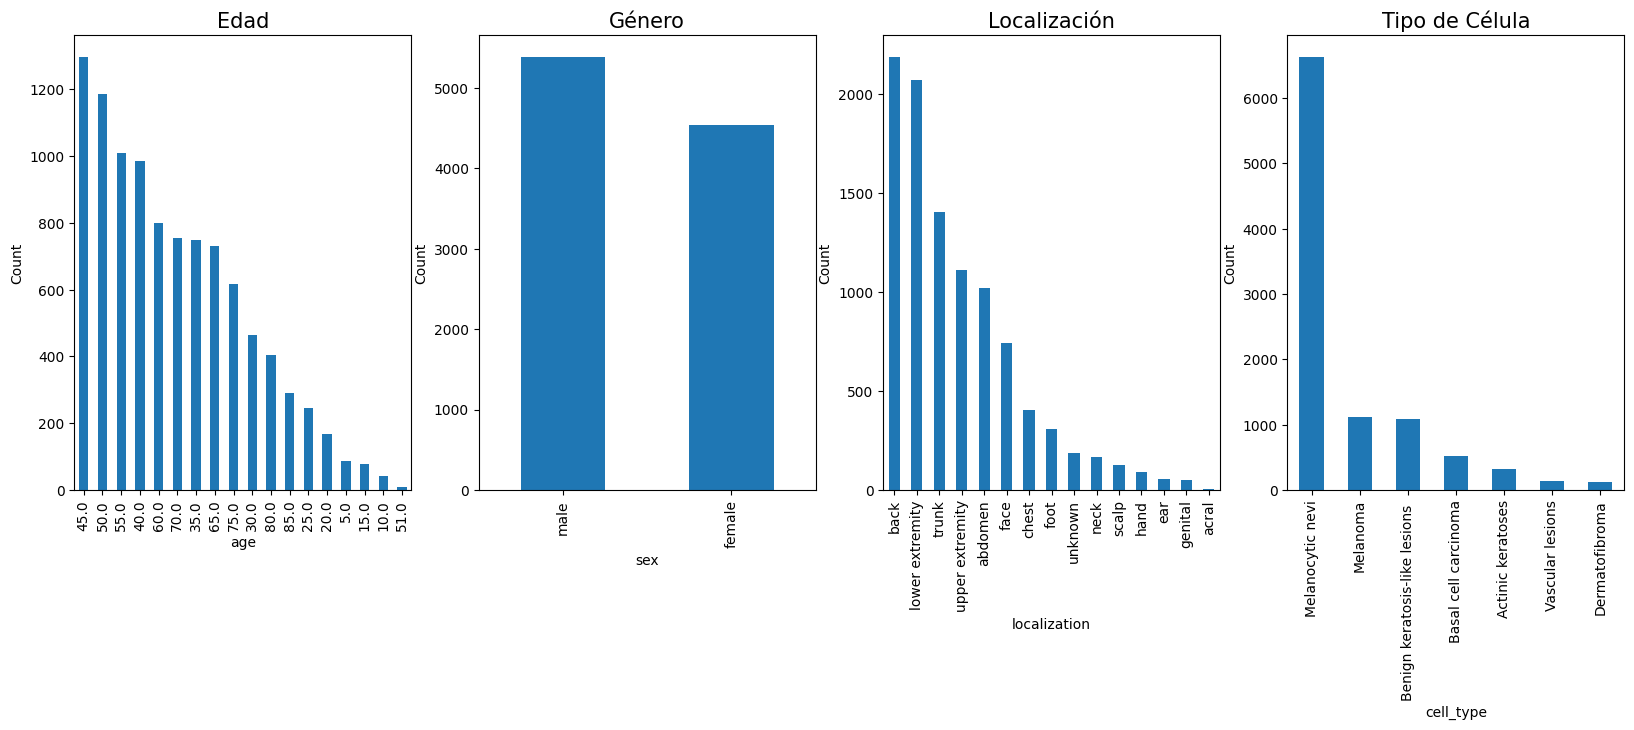

In [ ]:
#análisis univariado
metadata= metadata[metadata['age'] != 0]
metadata= metadata[metadata['sex'] != 'unknown']
plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0.125, bottom=1, right=0.9, top=2, hspace=0.2)
plt.subplot(2,4,1)
plt.title("Edad",fontsize=15)
plt.ylabel("Count")
metadata['age'].value_counts().plot.bar()

plt.subplot(2,4,2)
plt.title("Género",fontsize=15)
plt.ylabel("Count")
metadata['sex'].value_counts().plot.bar()

plt.subplot(2,4,3)
plt.title("Localización",fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation=45)
metadata['localization'].value_counts().plot.bar()

plt.subplot(2,4,4)
plt.title("Tipo de Célula",fontsize=15)
plt.ylabel("Count")
metadata['cell_type'].value_counts().plot.bar()

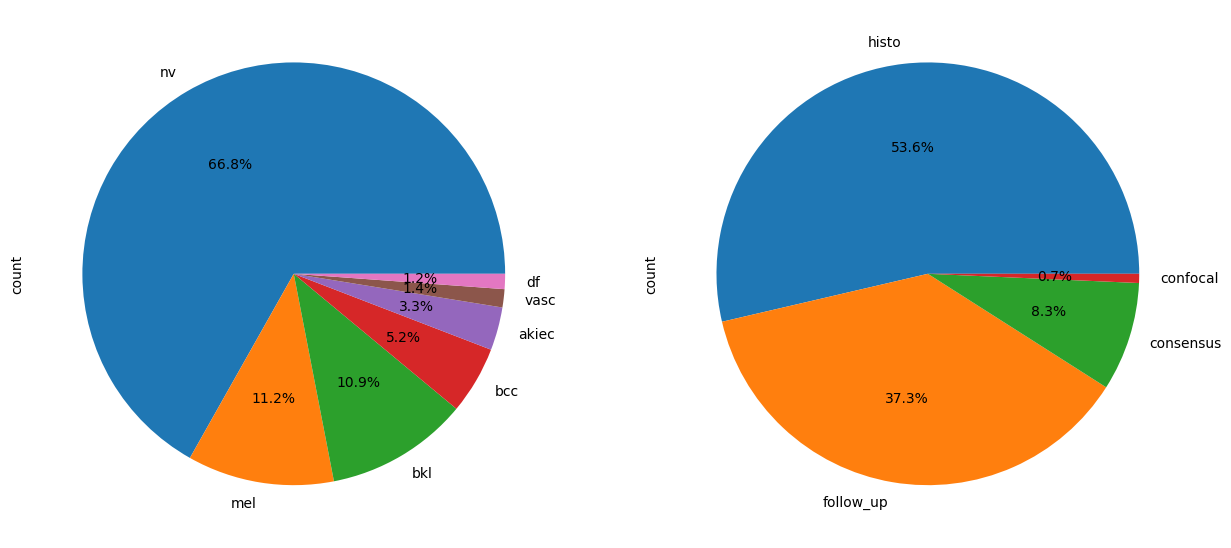

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
metadata['dx'].value_counts().plot.pie(autopct="%1.1f%%")
plt.subplot(1,2,2)
metadata['dx_type'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

<Axes: title={'center': 'LOCALIZACION VS GENERO'}, xlabel='count', ylabel='localization'>

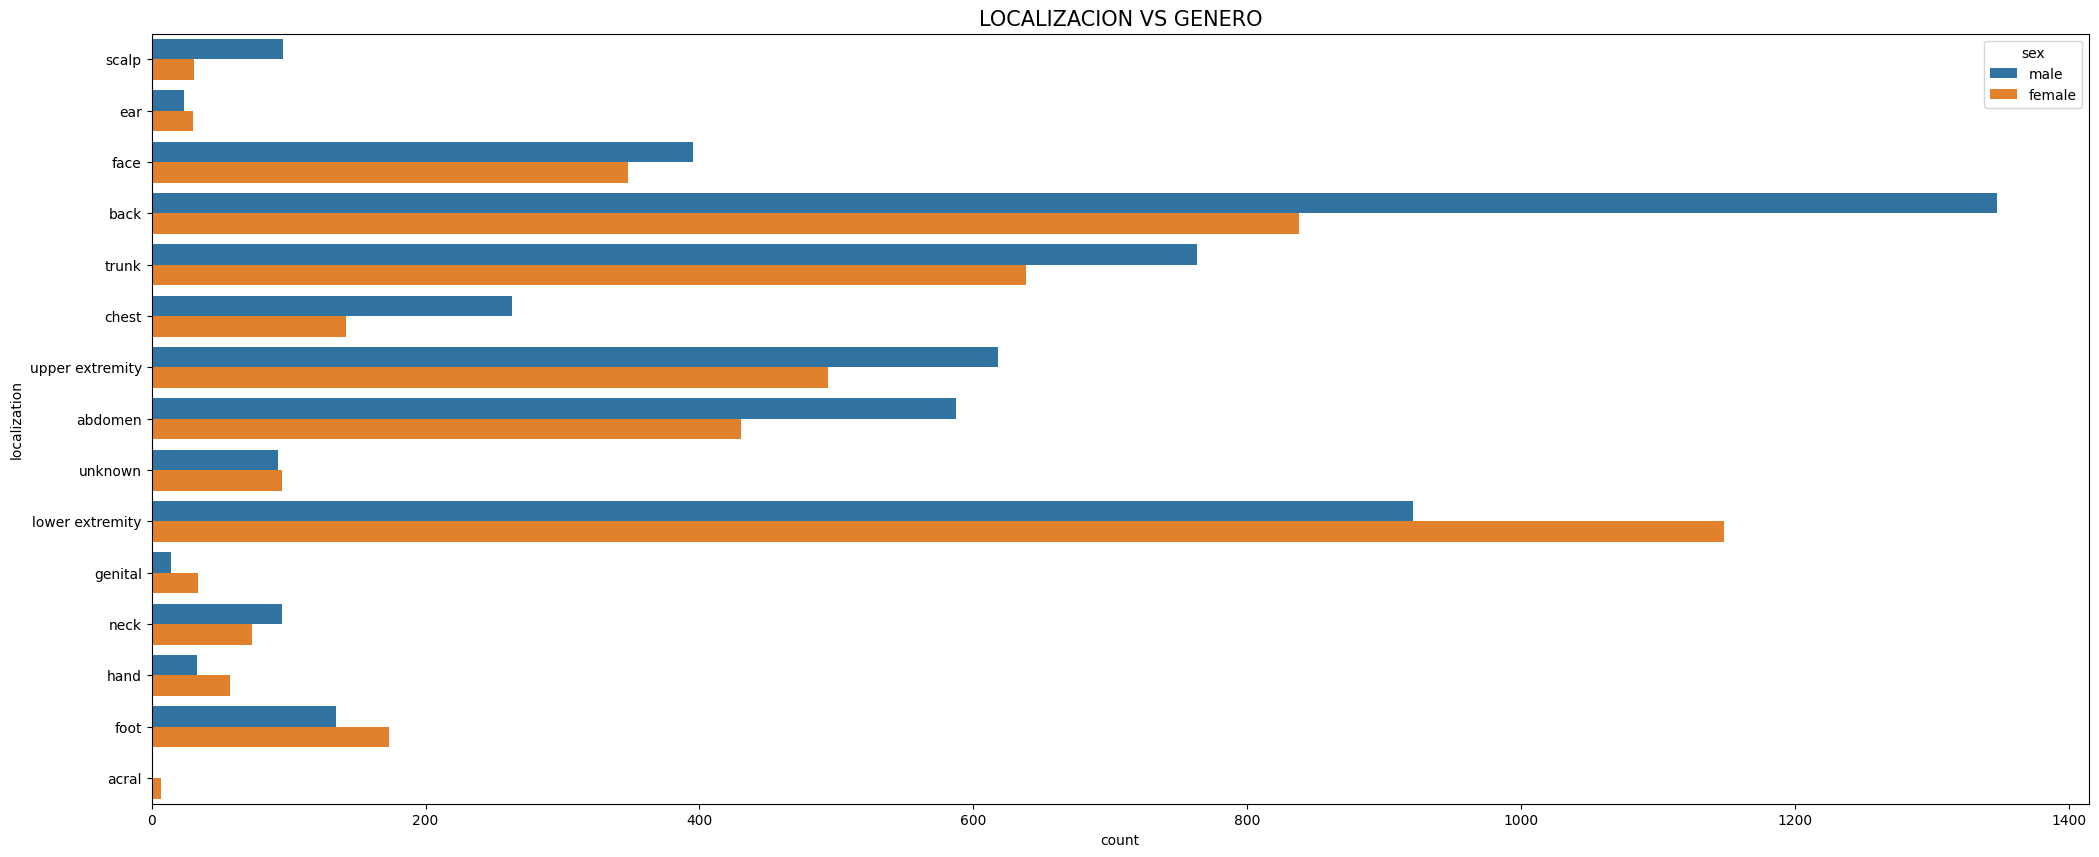

In [ ]:
#análisis bivariado
plt.figure(figsize=(25,10))
plt.title('LOCALIZACION VS GENERO',fontsize = 15)
sns.countplot(y='localization', hue='sex',data=metadata)

<Axes: title={'center': 'LOCALIZACION VS TIPO DE CELULA'}, xlabel='count', ylabel='localization'>

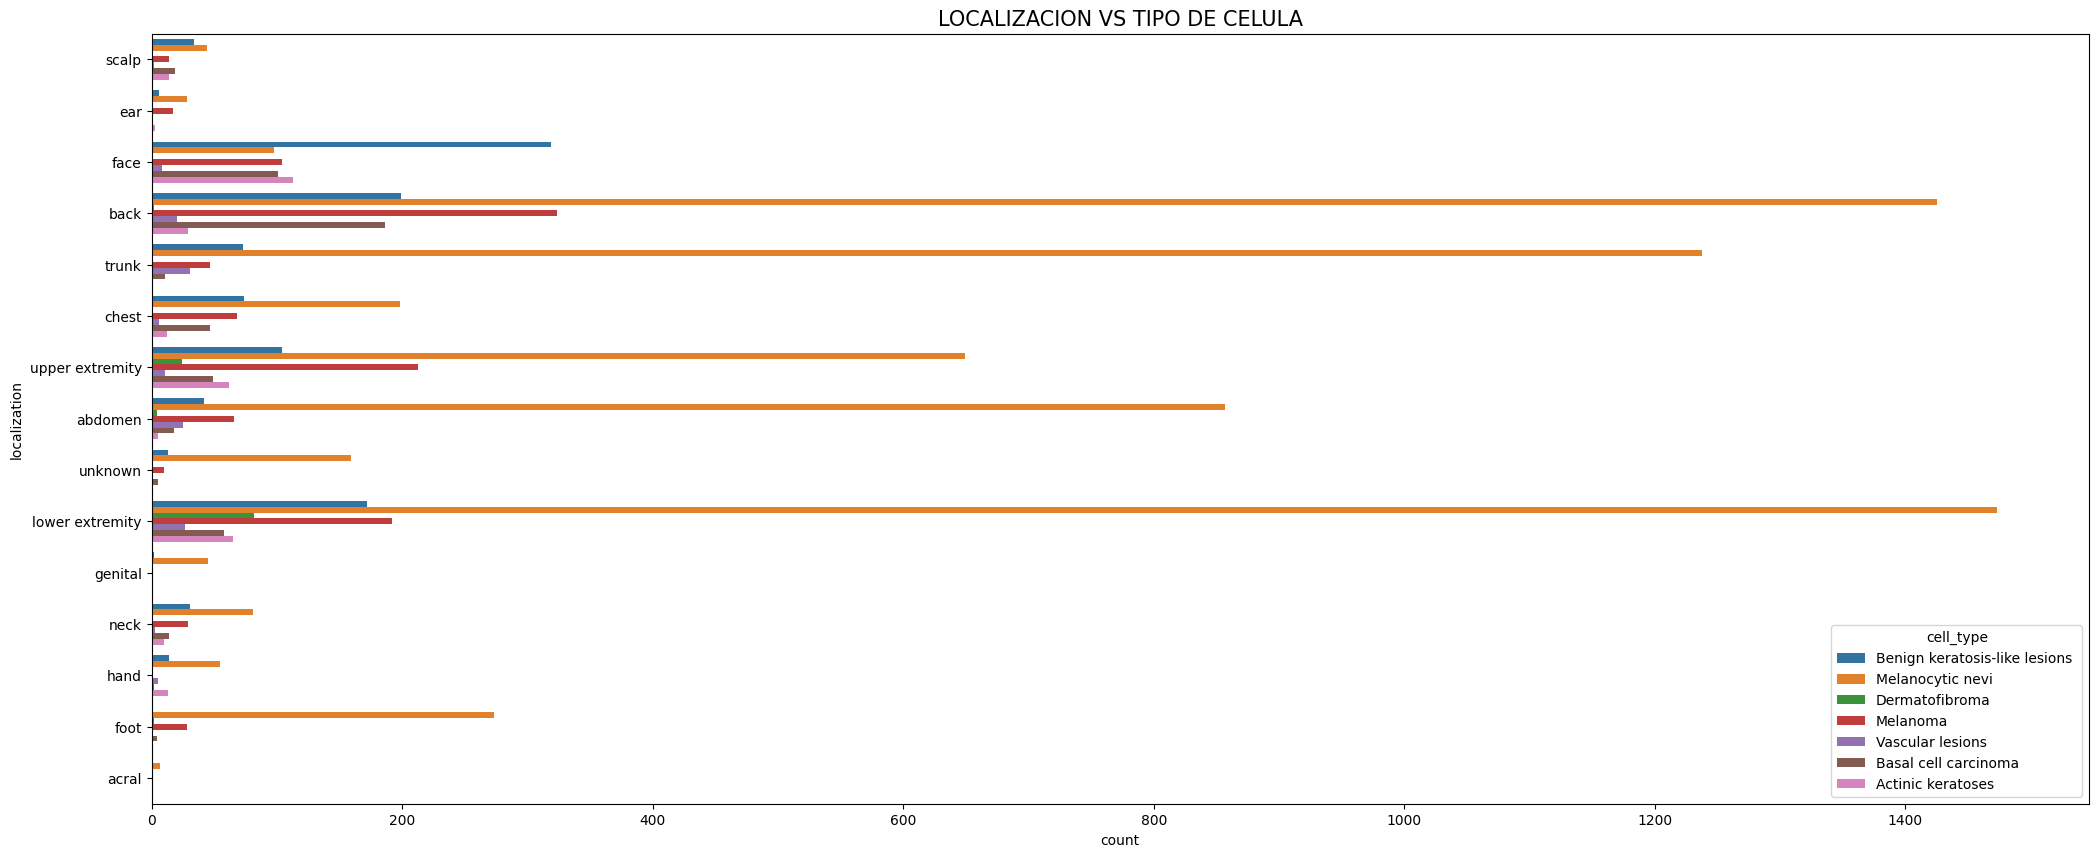

In [ ]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZACION VS TIPO DE CELULA',fontsize = 15)
sns.countplot(y='localization', hue='cell_type',data=metadata)

<Axes: title={'center': 'GENERO VS TIPO DE CELULA'}, xlabel='count', ylabel='sex'>

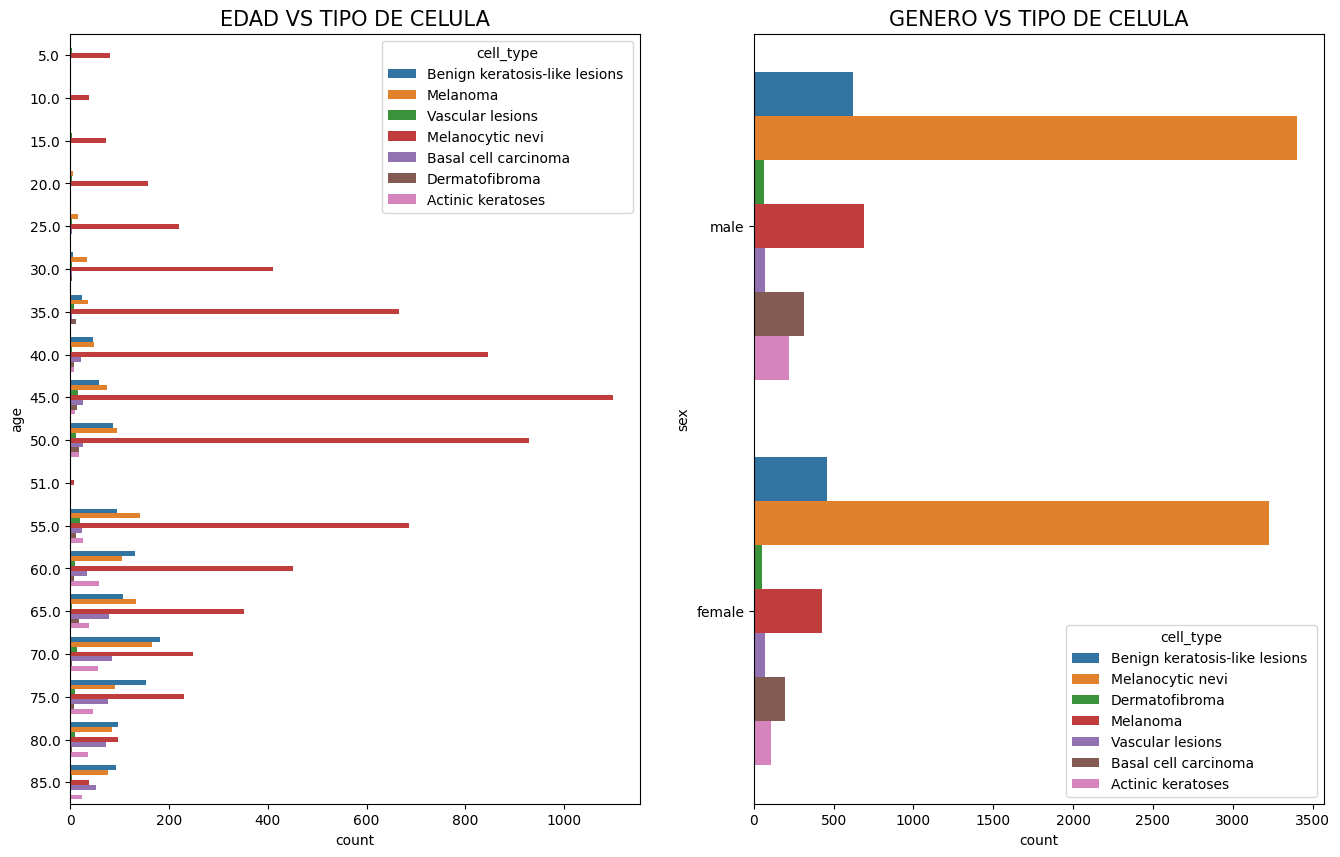

In [ ]:
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.title('EDAD VS TIPO DE CELULA',fontsize = 15)
sns.countplot(y='age', hue='cell_type',data=metadata)
plt.subplot(132)
plt.title('GENERO VS TIPO DE CELULA',fontsize = 15)
sns.countplot(y='sex', hue='cell_type',data=metadata)

## Procesamiento de Datos
El código carga imágenes de carpetas, las convierte en datos tabulares con etiquetas, y guarda o carga esta información en archivos CSV.

In [ ]:
train_csv_file = os.path.join(base_skin_dir, 'train_images_labels.csv')
val_csv_file = os.path.join(base_skin_dir, 'val_images_labels.csv')

#crear archivos CSV si no existen
if not os.path.exists(train_csv_file) or not os.path.exists(val_csv_file):
    train_data, train_labels = [], []
    val_data, val_labels = [], []

    def load_images_from_dir(dir, data_list, labels_list):
        for label in os.listdir(dir):
            label_dir = os.path.join(dir, label)
            if os.path.isdir(label_dir):
                for image_file in os.listdir(label_dir):
                    if image_file.endswith(('.png', '.jpg', '.jpeg')):
                        image_path = os.path.join(label_dir, image_file)
                        image = Image.open(image_path).convert('RGB')
                        image = image.resize((28, 28))
                        image_array = np.array(image).flatten()
                        data_list.append(image_array)
                        labels_list.append(label)

    #cargar imagenes
    load_images_from_dir(train_dir, train_data, train_labels)
    load_images_from_dir(val_dir, val_data, val_labels)

    #crear dataframe y guardar csv
    df_train = pd.DataFrame(train_data)
    df_train['label'] = train_labels
    df_val = pd.DataFrame(val_data)
    df_val['label'] = val_labels
    df_train.to_csv(train_csv_file, index=False)
    df_val.to_csv(val_csv_file, index=False)

    print(f"Archivos CSV creados: {train_csv_file}, {val_csv_file}")
else:
    print("Los archivos CSV ya existen. Cargando datos de los archivos existentes.")

#cargar archivos csv
if os.path.exists(train_csv_file) and os.path.exists(val_csv_file):
    train_data = pd.read_csv(train_csv_file)
    val_data = pd.read_csv(val_csv_file)

    #separacion de caracteristicas y etiquetas
    X_train = train_data.drop('label', axis=1)
    y_train = train_data['label']
    X_val = val_data.drop('label', axis=1)
    y_val = val_data['label']

    #combinacion de etiquetas para manetener consistencia
    all_labels = pd.concat([y_train, y_val]).unique()
    le = LabelEncoder()
    le.fit(all_labels)
    y_train_encoded = le.transform(y_train)
    y_val_encoded = le.transform(y_val)

    print("Fin de carga de datos")


Los archivos CSV ya existen. Cargando datos de los archivos existentes.
Fin de carga de datos


##SMOTE
SMOTE (Synthetic Minority Over-sampling Technique) es una técnica utilizada para equilibrar conjuntos de datos desbalanceados, es decir, aquellos en los que una clase está representada por muchas menos muestras que otras.

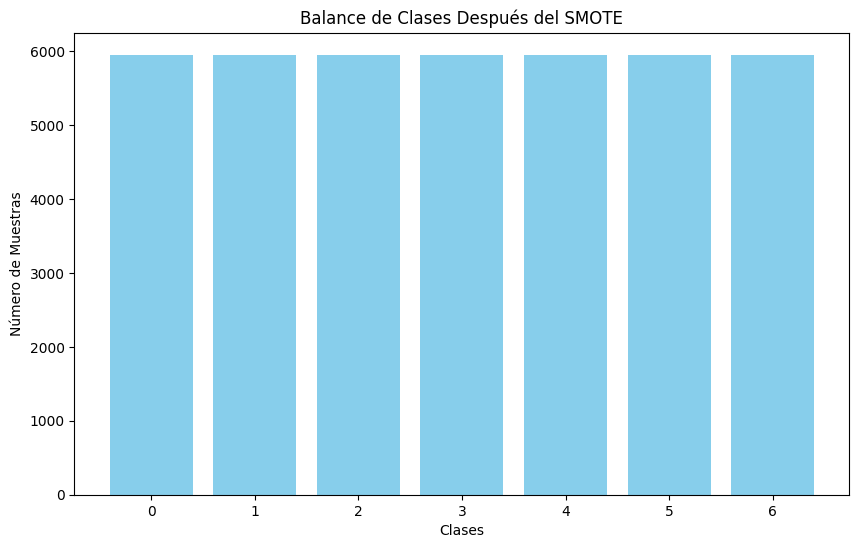

In [ ]:
#SMOTE OVERSAMPLING
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train_encoded)
X_train_balanced = X_train_balanced.to_numpy()

#graficar
def plotDataBalance(Y, title="Balance de Clases Después del SMOTE"):
    counter = Counter(Y)
    classes = list(counter.keys())
    counts = list(counter.values())
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Clases')
    plt.ylabel('Número de Muestras')
    plt.title(title)
    plt.xticks(classes)
    plt.show()


plotDataBalance(y_train_balanced)

##Cálculos de los pesos de las clases.

In [ ]:
#class weight (training)
from collections import Counter
class_counts_train = {
    'akiec': 301,
    'bcc': 484,
    'bkl': 1024,
    'df': 109,
    'mel': 1074,
    'nv': 5954,
    'vasc': 131,

}
total_samples_train = sum(class_counts_train.values())
class_weights_val = {cls: total_samples_train / count for cls, count in class_counts_train.items()}
print("Pesos de clase:", class_weights_val)
encoded_class_weights_val = {
    0: class_weights_val['akiec'],
    1: class_weights_val['bcc'],
    2: class_weights_val['bkl'],
    3: class_weights_val['df'],
    4: class_weights_val['mel'],
    5: class_weights_val['nv'],
    6: class_weights_val['vasc'],

}
sample_weights = np.array([encoded_class_weights_val[cls] for cls in y_train_balanced])
print("Número de pesos de muestra:", len(sample_weights))

Pesos de clase: {'akiec': 30.156146179401993, 'bcc': 18.75413223140496, 'bkl': 8.8642578125, 'df': 83.27522935779817, 'mel': 8.451582867783985, 'nv': 1.5245213301981861, 'vasc': 69.29007633587786}
Número de pesos de muestra: 41678


##XGBoost y Hyperopt

XGBoost

*   Basado en árboles de decisión.
*   Implementa un proceso "boosting", en el que múltiples árboles de decisión se construyen de manera secuencial. Cada nuevo árbol se entrena para corregir los errores de los árboles anteriores.
*   Asignación de peso: Inicialmente, cada observación tiene el mismo peso. Después de cada paso, el algoritmo ajusta estos pesos.
*   Agregado de predicciones: En lugar de que cada árbol haga una predicción final, los resultados de todos los árboles se combinan.

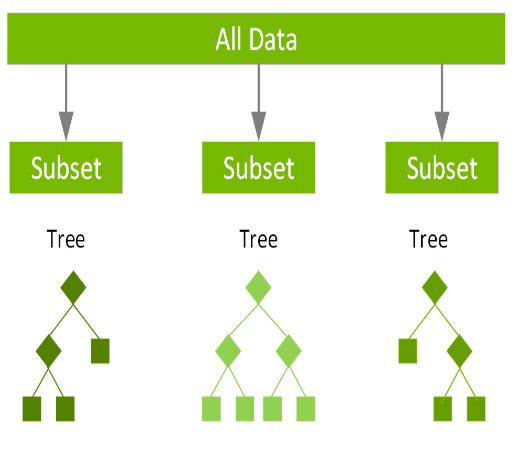

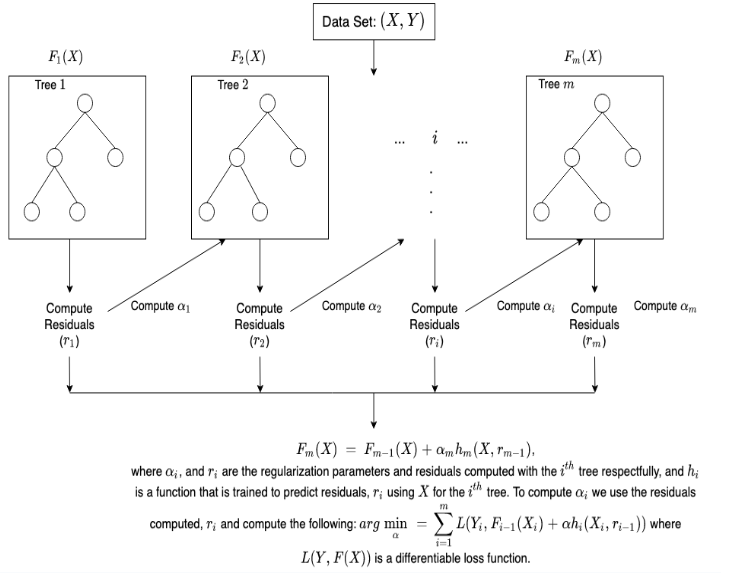






Este código optimiza los hiperparámetros de un modelo XGBoost para un problema de clasificación multiclase utilizando Hyperopt, basándose en la métrica de average precision score para encontrar la mejor configuración de hiperparámetros que maximice el rendimiento del modelo en un conjunto de validación.






##Accuracy, Precision, Recall


*   **Accuracy:** Es el porcentaje de predicciones correctas sobre el total de predicciones.

*   **Precision:** Mide la exactitud de las predicciones positivas.
Elemento de la lista

*   **Recall:** capacidad del modelo para detectar todas las instancias positivas.

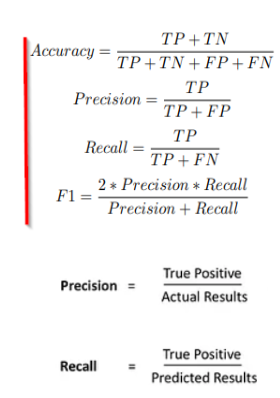





##Optimización de hiperparámetros.

**max_depth:** profundidad máxima de los árboles.

**learning_rate:** determina cuánto ajusta el modelo en cada iteración.

**subsample:** proporción de muestras utilizadas para entrenar cada árbol.

**colsample_bytree:** porcentaje de características usadas para entrenar cada
árbol. Ayuda a reducir la correlación entre árboles.

**gamma:** umbral mínimo de mejora en la pérdida para realizar una división en un nodo del árbol.

**max_delta_step:** límite máximo de cambio en las predicciones en cada iteración. Útil para resolver problemas de clases desbalanceadas.

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import average_precision_score
import xgboost as xgb

#crear DMatrix para entrenamiento y validación
feature_names = [str(i) for i in range(X_train_balanced.shape[1])]
dtrain_balanced = xgb.DMatrix(data=X_train_balanced, label=y_train_balanced, feature_names=feature_names)
dtrain_balanced.set_weight(sample_weights)
dval = xgb.DMatrix(data=X_val, label=y_val_encoded, feature_names=feature_names)

#rango de búsqueda para hyperopt
space = {
    'max_depth': hp.randint('max_depth', 5, 8),
    'learning_rate': hp.uniform('learning_rate', 0.1, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'max_delta_step': hp.quniform('max_delta_step', 0, 10, 1), #se realizo en el otro bloque
    'num_boost_round': hp.quniform('num_boost_round', 50, 500, 10), #se realizo en el otro bloque
    'early_stopping_rounds': hp.quniform('early_stopping_rounds', 10, 50, 5),#se realizo en el otro bloque
}

#parametros
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['num_boost_round'] = int(params['num_boost_round'])
    params['early_stopping_rounds'] = int(params['early_stopping_rounds'])
    params['objective'] = 'multi:softprob'
    params['num_class'] = 7
    params['eval_metric'] = 'auc'

    #entrenar el modelo
    model = xgb.train(params, dtrain_balanced, num_boost_round=params['num_boost_round'],
                      evals=[(dval, 'validation')],
                      early_stopping_rounds=params['early_stopping_rounds'], verbose_eval=False)

    #predecir en el conjunto de validación
    preds_proba = model.predict(dval)
    average_precision = average_precision_score(y_val_encoded, preds_proba, average='macro')
    return {'loss': -average_precision, 'status': STATUS_OK}

#ejecutar
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=25,  #número de combinaciones a probar
            trials=trials)

print("Mejores hiperparámetros:", best)


  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:35:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)



  0%|          | 0/25 [00:39<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

##Optimización de hiperparámetros (gamma, max_delta_step, num_boost_round, early_stopping_rounds)




In [ ]:
#entrenar gamma. delta, num boost y early stop
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import average_precision_score
import xgboost as xgb


feature_names = [str(i) for i in range(X_train_balanced.shape[1])]
dtrain_balanced = xgb.DMatrix(data=X_train_balanced, label=y_train_balanced, feature_names=feature_names)
dtrain_balanced.set_weight(sample_weights)
dval = xgb.DMatrix(data=X_val, label=y_val_encoded, feature_names=feature_names)

#optimizados previos
optimized_params = {
    'colsample_bytree': 0.9640,
    'learning_rate': 0.1908,
    'max_depth': 7,
    'subsample': 0.6026
}

space = {
    'gamma': hp.uniform('gamma', 0, 5),
    'max_delta_step': hp.quniform('max_delta_step', 0, 10, 1),
    'num_boost_round': hp.quniform('num_boost_round', 50, 500, 10),
    'early_stopping_rounds': hp.quniform('early_stopping_rounds', 10, 50, 5)
}

def objective(params):
    params.update(optimized_params)
    params['max_depth'] = int(params['max_depth'])
    num_boost_round = int(params.pop('num_boost_round'))
    early_stopping_rounds = int(params.pop('early_stopping_rounds'))
    params['objective'] = 'multi:softprob'
    params['num_class'] = 7
    params['eval_metric'] = 'auc'


    model = xgb.train(params, dtrain_balanced, num_boost_round=num_boost_round,
                      evals=[(dval, 'validation')],
                      early_stopping_rounds=early_stopping_rounds, verbose_eval=False)


    preds_proba = model.predict(dval)
    average_precision = average_precision_score(y_val_encoded, preds_proba, average='macro')
    return {'loss': -average_precision, 'status': STATUS_OK}


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=25,
            trials=trials)

print("Mejores hiperparámetros (incluyendo gamma y max_delta_step):", best)


  0%|          | 0/25 [00:43<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

Entrenamiento del modelo con los mejores hiperparámetros

In [ ]:
feature_names = [str(i) for i in range(X_train_balanced.shape[1])]

dtrain_balanced = xgb.DMatrix(data=X_train_balanced, label=y_train_balanced, weight=sample_weights, feature_names=feature_names)
dval = xgb.DMatrix(data=X_val, label=y_val_encoded, feature_names=feature_names)


params = {
    'objective': 'multi:softprob',
    'num_class': 7,
    'eval_metric': 'aucpr',
    'max_depth': 7,
    'learning_rate': 0.19082652445217993,
    'subsample': 0.6026054266059933,
    'colsample_bytree': 0.9640191683165567,
    'gamma': 0.17407261196923207,
    'max_delta_step': 5
}


evals = [(dtrain_balanced, 'train'), (dval, 'validation')]
xgb_model = xgb.train(
    params,
    dtrain_balanced,
    num_boost_round=int(190),  #parámetro optimizado #190
    evals=evals,
    early_stopping_rounds=int(30),  #parámetro optimizado #30
    verbose_eval=True
)


[0]	train-aucpr:0.72972	validation-aucpr:0.24882
[1]	train-aucpr:0.80125	validation-aucpr:0.29513
[2]	train-aucpr:0.83660	validation-aucpr:0.33936
[3]	train-aucpr:0.85790	validation-aucpr:0.36119
[4]	train-aucpr:0.87584	validation-aucpr:0.38468
[5]	train-aucpr:0.89012	validation-aucpr:0.40468
[6]	train-aucpr:0.90186	validation-aucpr:0.40675
[7]	train-aucpr:0.91249	validation-aucpr:0.41311
[8]	train-aucpr:0.92172	validation-aucpr:0.42467
[9]	train-aucpr:0.92940	validation-aucpr:0.42946
[10]	train-aucpr:0.93565	validation-aucpr:0.43645
[11]	train-aucpr:0.94229	validation-aucpr:0.44271
[12]	train-aucpr:0.94801	validation-aucpr:0.45185
[13]	train-aucpr:0.95420	validation-aucpr:0.45913
[14]	train-aucpr:0.95924	validation-aucpr:0.46388
[15]	train-aucpr:0.96357	validation-aucpr:0.47454
[16]	train-aucpr:0.96718	validation-aucpr:0.48266
[17]	train-aucpr:0.96957	validation-aucpr:0.49251
[18]	train-aucpr:0.97208	validation-aucpr:0.49493
[19]	train-aucpr:0.97468	validation-aucpr:0.50322
[20]	train

In [ ]:
xgb_model.save_model(f"{data_path}/modeloCancer.json")
xgb_model.save_model(f"{data_path}/modeloSkinCancer.bin")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:24:11] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


##Resultados de Entrenamiento:

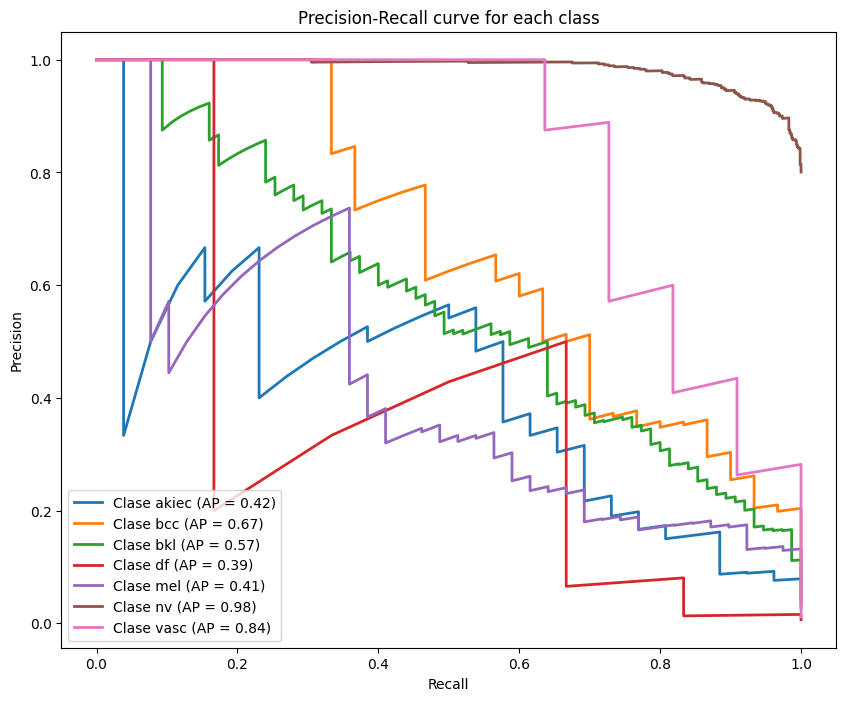

In [ ]:
#bajo curva
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
y_val_binarized = label_binarize(y_val_encoded, classes=np.arange(params['num_class']))

#calcular las probabilidades para cada clase
y_val_pred_prob = xgb_model.predict(dval)

average_precision = {}
for i in range(params['num_class']):
    average_precision[i] = average_precision_score(y_val_binarized[:, i], y_val_pred_prob[:, i])


plt.figure(figsize=(10, 8))
for i in range(params['num_class']):
    precision, recall, _ = precision_recall_curve(y_val_binarized[:, i], y_val_pred_prob[:, i])
    plt.plot(recall, precision, lw=2, label=f'Clase {le.classes_[i]} (AP = {average_precision[i]:0.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve for each class")
plt.legend(loc="best")
plt.show()

In [ ]:
y_val_pred_prob = xgb_model.predict(dval)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)  #clase con mayor probabilidad para cada pred
report = classification_report(y_val_encoded, y_val_pred, target_names=le.classes_)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       akiec       0.52      0.58      0.55        26
         bcc       0.59      0.63      0.61        30
         bkl       0.56      0.55      0.55        75
          df       0.44      0.67      0.53         6
         mel       0.36      0.54      0.43        39
          nv       0.94      0.91      0.92       751
        vasc       0.60      0.82      0.69        11

    accuracy                           0.84       938
   macro avg       0.57      0.67      0.61       938
weighted avg       0.86      0.84      0.85       938



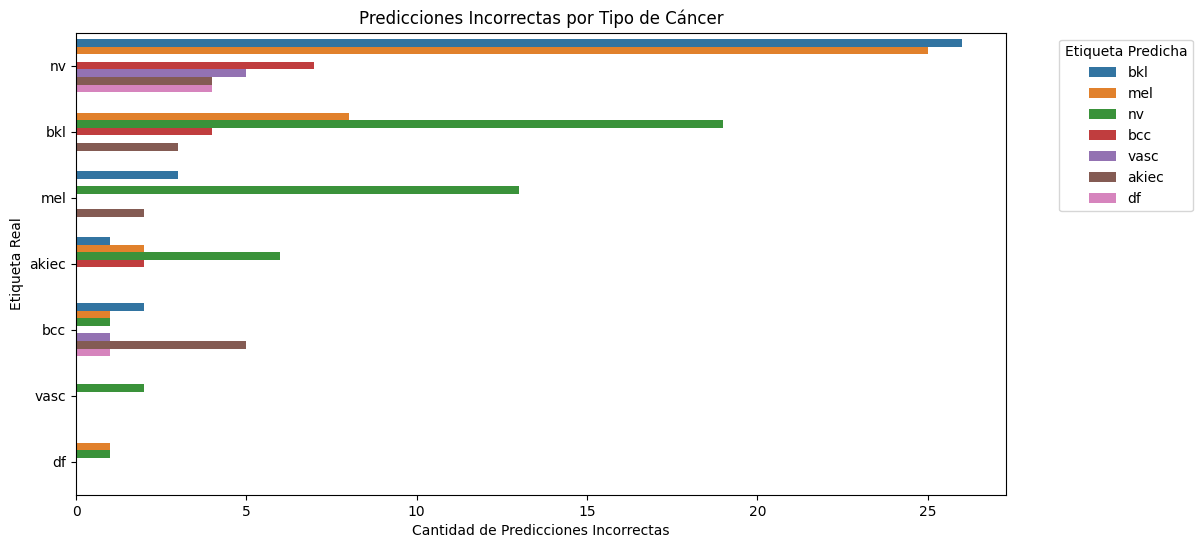

In [ ]:
#grafico predicciones incorrectas
results_df = pd.DataFrame({
    'True Label': le.inverse_transform(y_val_encoded),
    'Predicted Label': le.inverse_transform(y_val_pred)
})
#filtrar las predicciones incorrectas
incorrect_predictions = results_df[results_df['True Label'] != results_df['Predicted Label']]
#contar las ocurrencias de cada tipo de error
error_counts = incorrect_predictions.value_counts().reset_index(name='Count')
error_counts.columns = ['True Label', 'Predicted Label', 'Count']
#crear un gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(data=error_counts, x='Count', y='True Label', hue='Predicted Label', dodge=True)
plt.title('Predicciones Incorrectas por Tipo de Cáncer')
plt.xlabel('Cantidad de Predicciones Incorrectas')
plt.ylabel('Etiqueta Real')
plt.legend(title='Etiqueta Predicha', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

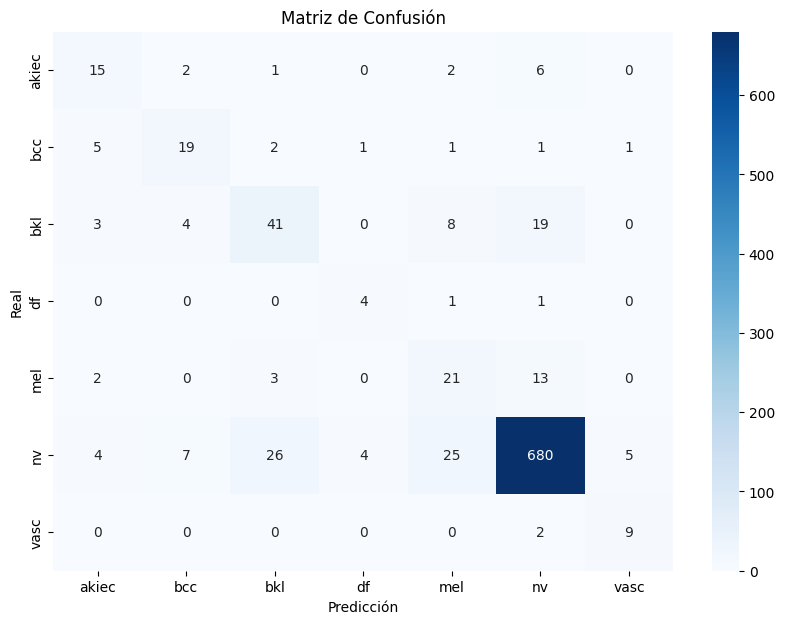

In [ ]:
y_val_pred_prob = xgb_model.predict(dval)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
cm = confusion_matrix(y_val_encoded, y_val_pred)


def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

plot_confusion_matrix(cm, le.classes_)